In [1]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import umap
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# 连接input csv
citys=['BS']
# citys=['M']
firstflag=0
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*dim*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        if firstflag==0:
            df_input=pd.read_csv(csvname)
            firstflag=1
        else:
            df_input=df_input.append(pd.read_csv(csvname),ignore_index=True)
df_input=df_input.fillna(0)
df_input_store=df_input[['polarity','subjectivity','lon','lat']]
df_input.drop(['lon','lat','Unnamed: 0','bed_flag','polarity','subjectivity'],axis=1,inplace=True)
list_county=[w for w in df_input.columns if w[0:6]=='county']
df_input.drop(list_county,axis=1,inplace=True)
df_input=df_input.astype(int)
df_input=pd.concat([df_input,df_input_store],axis=1)
df_input.drop(df_input[df_input['price_last']==0].index,axis=0,inplace=True)
df_input.reset_index(drop=True,inplace=True)

UBDC/sale_2020/BS/00007_diminput.csv
UBDC/sale_2020/BS/00006_diminput.csv
UBDC/sale_2020/BS/00001_diminput.csv
UBDC/sale_2020/BS/00000_diminput.csv
UBDC/sale_2020/BS/00005_diminput.csv
UBDC/sale_2020/BS/00004_diminput.csv
UBDC/sale_2020/BS/00002_diminput.csv
UBDC/sale_2020/BS/00003_diminput.csv


In [3]:
# gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
# bm=gdf[gdf['TCITY15NM']=='Bristol']
# bm=bm.to_crs("epsg:27700")
# gdf_input=gpd.GeoDataFrame(df_input[['lon','lat']],geometry=gpd.points_from_xy(df_input.lon, df_input.lat, crs='epsg:4326'))
# gdf_input=gdf_input.to_crs("epsg:27700")
# gdf_input=gpd.sjoin(gdf_input,bm[['geometry']], how="inner", op='intersects').reset_index()
# london_index=gdf_input['index']
# df_input=df_input.iloc[london_index]
num0col=pd.DataFrame(df_input.sum()) #remove sum=0 columns
col=num0col[num0col[0]==0].index
df_input.drop(col,axis=1,inplace=True)
df_input.reset_index(drop=True,inplace=True)

In [4]:
df_input

,end_date,price_last,num_bed_last,num_floors_max,num_bath_max,num_reception_max,glaze,radiator,bristol,garden,...,property_type_Mews house,lad20nm_Mendip,property_type_Block of flats,property_type_Leisure/hospitality,property_type_Office,property_type_Farm,polarity,subjectivity,lon,lat
0,392,330000,4,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0.115952,0.426772,-2.481889,51.490974
1,35,250000,3,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0.086364,0.262121,-2.483179,51.474514
2,130,325000,3,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0.131769,0.327134,-2.486652,51.482536
3,293,325000,3,0,1,2,1,0,0,0,...,0,0,0,0,0,0,0.169298,0.383232,-2.549109,51.463505
4,547,135000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.195362,0.385435,-2.774169,51.475990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50547,309,100000,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.167045,0.360985,-2.960846,51.309433
50548,115,325000,3,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0.155100,0.407366,-2.475595,51.484188
50549,428,215000,2,0,1,2,0,0,1,1,...,0,0,0,0,0,0,0.283692,0.450060,-2.681034,51.495110
50550,521,250000,3,0,1,1,0,1,0,0,...,0,0,0,0,0,0,-0.065579,0.511214,-2.797381,51.390730


In [5]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

lasso

In [6]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x, y=train_y)

CPU times: user 38.2 s, sys: 1min 36s, total: 2min 14s
Wall time: 9.57 s


Lasso(normalize=True)

In [7]:
lasso_model.score(X=train_x, y=train_y)

0.6563621074803219

In [8]:
lasso_model.score(X=test_x, y=test_y)

0.6307221161282195

In [9]:
%%time
from sklearn.linear_model import LassoCV
alphas = 10**np.linspace(- 3, 3, 100) 
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 20, max_iter= 500000).fit(train_x, train_y)

CPU times: user 10min 22s, sys: 16min 15s, total: 26min 37s
Wall time: 6min 35s


In [20]:
# 0.5336699231206312
best_alpha=lasso_cv.alpha_
lasso_model = Lasso(max_iter=10e7, normalize=True, alpha = best_alpha)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(test_x, test_y))

0.6307528323887013


In [12]:
pd.set_option('display.max_rows', 200)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
useless_var=df_coef_lasso[df_coef_lasso.coef==0]['var'].values
useless_var

array(['website', 'elevation', 'unit', 'integral', 'velux', 'extractor',
       'white', 'bulletin_board', 'courtyard', 'slide', 'heating',
       'republish_retransmit', 'potential', 'bristol_temple', 'material',
       'subject', 'ample', 'maximum', 'ashton', 'harbourside', 'timber',
       'church', 'spacious', 'statements_pertain', 'lens_query',
       'relevant_contractor', 'pack', 'panelled', 'obscured', 'hang',
       'southville_delighted', 'incur', 'email', 'store', 'landscape',
       'thornbury', 'purchase', 'leasehold', 'log_burner', 'site',
       'condition', 'property_type_Cottage',
       'lad20nm_Bath and North East Somerset',
       'lad20nm_South Gloucestershire', 'property_type_Office'],
      dtype=object)

continue connect data

In [4]:
df_input=df_input.rename(columns={'end_date':'date_since_2019','num_bed_last':'num_bed',
'num_floors_max':'num_floors',
 'num_bath_max':'num_bath',
 'num_reception_max':'num_reception',
'polarity':"sentiment_polarity",
 'subjectivity':'sentiment_subjectivity'})
useless_var=['website', 'elevation', 'unit', 'integral', 'velux', 'extractor',
       'white', 'bulletin_board', 'courtyard', 'slide', 'heating',
       'republish_retransmit', 'potential', 'bristol_temple', 'material',
       'subject', 'ample', 'maximum', 'ashton', 'harbourside', 'timber',
       'church', 'spacious', 'statements_pertain', 'lens_query',
       'relevant_contractor', 'pack', 'panelled', 'obscured', 'hang',
       'southville_delighted', 'incur', 'email', 'store', 'landscape',
       'thornbury', 'purchase', 'leasehold', 'log_burner', 'site',
       'condition', 'property_type_Cottage',
       'lad20nm_Bath and North East Somerset',
       'lad20nm_South Gloucestershire', 'property_type_Office']
df_input.drop(useless_var,axis=1,inplace=True)
notext_index=df_input[df_input.iloc[:,5:486].T.sum()==0].index #去掉单词列全为零的行
df_input.drop(notext_index,axis=0,inplace=True)

In [17]:
df_input.to_csv('bs_dim1.csv',index=False) #去掉lasso的无用变量
df_input[['lon','lat']].to_csv('bs_dim_lonlat1.csv',index=False)

# test set

In [33]:
# notext+sen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [35]:
# nosen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [29]:
# notext
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [19]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x_notext, y=train_y_notext)
print(lasso_model.score(X=train_x_notext, y=train_y_notext),'\n',lasso_model.score(X=test_x_notext, y=test_y_notext))

0.5007610079660813 
 0.485539469618808
CPU times: user 1.7 s, sys: 5.48 s, total: 7.18 s
Wall time: 467 ms


regression tree

In [5]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-len(useless_var)+1]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)

In [23]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.9999911304030034
R2 on the testing data:
0.7999381464069438
RMSE on the training data:
534.6185079046693
RMSE on the testing data:
80538.11155408187


In [30]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x_notext, train_y_notext)
print("R2 on the training data:")
print(reg_tree.score(X=train_x_notext, y=train_y_notext))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x_notext, y=test_y_notext))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y_notext, reg_tree.predict(train_x_notext), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y_notext, reg_tree.predict(test_x_notext), squared=False))

R2 on the training data:
0.9999907627621022
R2 on the testing data:
0.706072053178769
RMSE on the training data:
545.5858649516699
RMSE on the testing data:
97620.21020206569


random forest

In [36]:
%%time
# 没文本变量的

from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=200, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x_notext,train_y_notext)
print("R2 on the training data:")
print(rf.score(train_x_notext,train_y_notext))
print("R2 on the testing data:")
print(rf.score(test_x_notext,test_y_notext))

R2 on the training data:
0.9857376414902269
R2 on the testing data:
0.8757452257199806
CPU times: user 19min 20s, sys: 0 ns, total: 19min 20s
Wall time: 1min 37s


In [6]:
%%time
from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=200, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x,train_y)
print("R2 on the training data:")
print(rf.score(train_x,train_y))
print("R2 on the testing data:")
print(rf.score(test_x,test_y))

R2 on the training data:
0.9853612413509385
R2 on the testing data:
0.8742790852712523
CPU times: user 25min 57s, sys: 16.8 s, total: 26min 14s
Wall time: 1min 41s


In [42]:
pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=f57669014b7d6a85c37c0fa3a399ea2bde820fbbb9bf219c059ff3f8feb9bd19
  Stored in directory: /home/jovyan/.cache/pip/wheels/d9/f2/53/6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp
Note: you may need to restart the kernel to use updated packages.


In [79]:
df_input

,date_since_2019,price_last,num_bed,num_floors,num_bath,num_reception,glaze,radiator,bristol,garden,...,property_type_Hotel/guest house,property_type_Mews house,lad20nm_Mendip,property_type_Block of flats,property_type_Leisure/hospitality,property_type_Farm,sentiment_polarity,sentiment_subjectivity,lon,lat
0,392,330000,4,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0.115952,0.426772,-2.481889,51.490974
1,35,250000,3,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0.086364,0.262121,-2.483179,51.474514
2,130,325000,3,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0.131769,0.327134,-2.486652,51.482536
3,293,325000,3,0,1,2,1,0,0,0,...,0,0,0,0,0,0,0.169298,0.383232,-2.549109,51.463505
4,547,135000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.195362,0.385435,-2.774169,51.475990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50547,309,100000,2,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0.167045,0.360985,-2.960846,51.309433
50548,115,325000,3,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0.155100,0.407366,-2.475595,51.484188
50549,428,215000,2,0,1,2,0,0,1,1,...,0,0,0,0,0,0,0.283692,0.450060,-2.681034,51.495110
50550,521,250000,3,0,1,1,0,1,0,0,...,0,0,0,0,0,0,-0.065579,0.511214,-2.797381,51.390730


                              Importance
Feature                                 
num_bed                         0.801145
sentiment_polarity              0.148933
property_type_Detached house    0.123982
clifton                         0.109041
num_bath                        0.060919
...                                  ...
reach                          -0.000059
accommodation                  -0.000090
causeway                       -0.000103
building                       -0.000133
heart                          -0.000371

[498 rows x 1 columns]


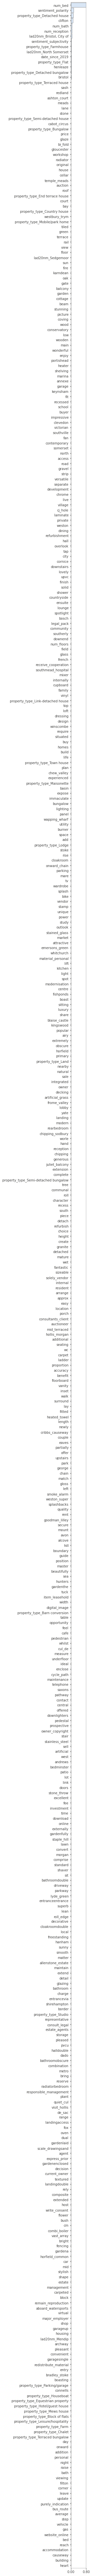

In [7]:
import rfpimp
imp = rfpimp.importances(rf, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [8]:
imp[0:50].to_csv('bs_sig50.csv')

In [30]:
%%time
# cross va
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
X_train_val = pd.concat([train_x,test_x])
y_train_val = pd.concat([train_y,test_y])
# values of n_estimators
parameters = {'n_estimators':[10,20,30,40,50,70,100,200]}
rf = RandomForestRegressor(n_jobs=-1)

# cv=5 by default, which means 5-fold cross-validation
clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(X_train_val, y_train_val)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'n_estimators': 200}
The best score is: 
0.8979133122389825
CPU times: user 12min 13s, sys: 13.3 s, total: 12min 26s
Wall time: 8min 4s


dim forgwr

In [31]:
gwr_x=df_input.drop(['price_last'],axis=1)
gwr_y=df_input[['price_last']]
gwr_xy=df_input[['lon','lat']]

In [32]:
gwr_x

,date_since_2019,num_bed,num_floors,num_bath,num_reception,glaze,radiator,bristol,garden,tiled,...,property_type_Terraced bungalow,property_type_Town house,lad20nm_Bath and North East Somerset,lad20nm_South Gloucestershire,property_type_Mews house,property_type_Block of flats,sentiment_polarity,sentiment_subjectivity,lon,lat
0,392,4,0,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0.115952,0.426772,-2.481889,51.490974
1,35,3,0,1,1,1,1,0,0,1,...,0,0,0,1,0,0,0.086364,0.262121,-2.483179,51.474514
2,130,3,0,0,0,1,1,0,1,1,...,0,0,0,1,0,0,0.131769,0.327134,-2.486652,51.482536
3,293,3,0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0.169298,0.383232,-2.549109,51.463505
4,483,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0.288233,0.609328,-2.603279,51.453860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26770,428,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.183571,0.322381,-2.502581,51.459210
26771,413,3,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0.087294,0.278561,-2.529869,51.482574
26772,163,2,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0.093992,0.406346,-2.662355,51.496895
26773,115,3,0,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0.155100,0.407366,-2.475595,51.484188


In [33]:
df_toUMAP=gwr_x.drop(['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity'],axis=1)
#  ,'luxury' ,'ideal', 'rare'
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=5,
    random_state=8)

arr_UMAP=reducer.fit_transform(df_toUMAP)

df_x_10=pd.DataFrame(arr_UMAP,columns= ['E'+str(x) for x in np.arange(0,5)])
gwr_x=pd.concat([gwr_x[['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity']],df_x_10],axis=1) 

gwr

In [34]:
# gwr input
# train_x=pd.read_csv('train_x.csv')[0:30000]
# train_y=pd.read_csv('train_y.csv')[0:30000]
# train_x_g=pd.read_csv('train_x_g.csv')[0:30000]
train_cor=list(zip(gwr_xy['lon'],gwr_xy['lat']))
# test_cor=list(zip(test_x['lon'],test_x['lat']))
train_x_g1=gwr_x.values
# test_x_g=test_x[gwr_var].values
train_y_g1 =gwr_y.values.reshape((-1,1))
# test_y_g =test_y.values.reshape((-1,1))
# train_cor1=train_cor[0:5000]
# train_y_g1=train_y_g[0:5000]
# train_x_g1=train_x_g[0:5000]

In [35]:
gwr_x

,date_since_2019,num_bed,num_bath,num_reception,sentiment_polarity,sentiment_subjectivity,E0,E1,E2,E3,E4
0,392,4,3,0,0.115952,0.426772,12.620764,5.064344,7.055200,3.075535,3.077099
1,35,3,1,1,0.086364,0.262121,9.976222,5.253757,6.724766,5.164549,1.897049
2,130,3,0,0,0.131769,0.327134,10.400549,4.590482,6.201653,5.203557,1.631397
3,293,3,1,2,0.169298,0.383232,8.733919,3.955889,7.012381,4.934781,2.898812
4,483,1,1,1,0.288233,0.609328,9.768924,2.594984,4.396772,9.125460,8.437412
...,...,...,...,...,...,...,...,...,...,...,...
26770,428,3,0,0,0.183571,0.322381,8.299994,4.381430,4.437292,6.461205,5.136059
26771,413,3,0,0,0.087294,0.278561,9.081980,3.791212,6.071739,4.097217,1.381912
26772,163,2,1,1,0.093992,0.406346,19.715336,12.114774,11.767373,5.919817,3.305991
26773,115,3,1,1,0.155100,0.407366,7.552948,4.477495,5.073251,6.819102,5.383261


In [36]:
%%time 
# bm 40000 116
gwr_selector = Sel_BW(train_cor[0:10000], train_y_g1[0:10000], train_x_g1[0:10000])
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor[0:20000], train_y_g1[0:20000], train_x_g1[0:20000],gwr_bw).fit()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.49623e-20): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/kernels.py:60: RuntimeWarning: divide by zero encountered in true_divide
  self.kernel = self._kernel_funcs(self.dvec / self.bandwidth)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/kernels.py:60: RuntimeWarning: invalid value encountered in true_divide
  self.kernel = self._kernel_funcs(self.dvec / self.bandwidth)


LinAlgError: Matrix is singular.

In [177]:
# 回归参数
var_names=['sentiment_polarity','sentiment_subjectivity']
gwr_coefficent=pd.DataFrame(gwr_results.params[:,4:6],columns=var_names)
# 回归参数显著性
# gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
# 将点数据回归结果放到面上展示
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉

georgia_data_geo=gpd.GeoDataFrame(gwr_coefficent,geometry=gpd.points_from_xy(gwr_xy[0:20000].lon, gwr_xy[0:20000].lat, crs='epsg:4326'))

# 将回归参数与面数据结合
# georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")
georgia_data_geo['lon']=gwr_xy[0:20000].lon
georgia_data_geo['lat']=gwr_xy[0:20000].lat

In [178]:
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
gwr_flter_t[gwr_flter_t[4]!=0]
georgia_data_geo_fil=georgia_data_geo.iloc[gwr_flter_t[gwr_flter_t[4]!=0].index.tolist()]
georgia_data_geo_fil.shape

(1801, 5)

In [170]:
georgia_data_geo_fil.to_csv('bm_gwr_pra1.csv')

In [150]:
train_x_g1[34950:35000]

array([[ 5.42000000e+02,  5.00000000e+00,  4.00000000e+00,
         1.00000000e+00,  9.28571429e-02,  3.67446634e-01,
         3.42484808e+00, -2.01717570e-01, -3.67370892e+00,
        -1.93291605e-01, -5.17126656e+00, -3.04200101e+00,
        -1.63450754e+00, -9.55181599e-01,  5.62445223e-01,
         3.33862472e+00],
       [ 4.34000000e+02,  4.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  1.49942681e-01,  4.89651675e-01,
         3.01767087e+00, -5.00838995e+00,  3.14439273e+00,
        -4.50597095e+00, -8.90417337e-01, -7.35535741e-01,
         1.62177241e+00,  2.28964901e+00,  3.82650948e+00,
         1.48865497e+00],
       [ 3.84000000e+02,  2.00000000e+00,  2.00000000e+00,
         1.00000000e+00,  1.34523810e-01,  4.50613276e-01,
         6.77980947e+00,  5.15123749e+00, -7.68817723e-01,
         5.06745815e+00, -3.94898616e-02,  1.04525983e+00,
         3.01890790e-01,  6.86266363e-01, -3.94835496e+00,
         2.59518623e+00],
       [ 1.42000000e+02,  4.00000000e

In [176]:
%%time 
# london 20000 116
gwr_selector = Sel_BW(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:])
gwr_bw = gwr_selector.search()
print('1')
gwr_results1 = GWR(train_cor[20000:], train_y_g1[20000:], train_x_g1[20000:],gwr_bw).fit()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.00361e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.84736e-38): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.11959e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.73667e-37): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.50641e-36): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/envs/sds2021/lib/py

LinAlgError: Matrix is singular.

In [180]:
c1=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']>40000]
c2=georgia_data_geo_fil[georgia_data_geo_fil['sentiment_polarity']<-40000]
df_clu=pd.concat([c1,c2]).reset_index(drop=True)
df_clu

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
0,71789.000362,606346.173699,POINT (403381.998 284625.087),-1.951654,52.459564
1,143594.127006,225856.052196,POINT (404658.007 285919.098),-1.932857,52.471188
2,172994.762758,910428.819788,POINT (407059.021 291640.091),-1.897392,52.522594
3,63271.776392,19935.520354,POINT (406545.065 284018.198),-1.905114,52.454080
4,73488.984626,382861.707515,POINT (403435.030 281559.051),-1.950904,52.432000
...,...,...,...,...,...
1735,-116123.965697,299823.781915,POINT (406780.429 286495.162),-1.901601,52.476345
1736,-115745.305445,297923.171668,POINT (406780.024 286493.938),-1.901607,52.476334
1737,-56259.497507,-396167.793653,POINT (403842.027 284680.142),-1.944883,52.460056
1738,-72307.264613,-387240.180333,POINT (403914.990 284782.979),-1.943808,52.460980


In [284]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
bm=gdf[gdf['TCITY15NM']=='Bristol']
bm=bm.to_crs("epsg:27700")
bm['geometry'] = bm['geometry'].buffer(-400)
# bm_msoas = gpd.sjoin(bm,msoas,op='contains') 
bm_msoas = gpd.sjoin(msoas,bm,op='intersects') 
bm_msoas.drop(['index_right'],axis=1,inplace=True)
bm_msoas_join=gpd.sjoin(bm_msoas,georgia_data_geo_fil)
msoagrdf = bm_msoas_join.groupby('MSOA11NM').agg({'sentiment_polarity':['mean'],'sentiment_subjectivity':['mean']}).reset_index()
msoagrdf.columns=['MSOA11NM','sentiment_polarity_mean','sentiment_subjectivity_mean']
bm_msoas_mean=pd.merge(bm_msoas,msoagrdf,on='MSOA11NM')

In [296]:
# bm['geometry'] = bm['geometry'].buffer(200)
bm=gdf[gdf['TCITY15NM']=='Bristol']
bm=bm.to_crs("epsg:27700")

In [275]:
delindex=[]
bm_msoas.reset_index(drop=True,inplace=True)
for count in range(bm_msoas.shape[0]):
    if bm_msoas['MSOA11NM'].iloc[count][0:6]!='Bristol':
        delindex.append(count)
    
bm_msoas.drop(delindex,axis=0,inplace=True)


In [299]:
df_clu=georgia_data_geo_fil

In [323]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.1
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-1.9282753740762009, 1.8267576580716651]
The range of lon is [-1.14817344260539, 2.2532138839787894]
The range of lat is [-0.8255970647853845, 0.8535789914728813]
The range of sentiment_subjectivity is [-0.9361704681025449, 1.3618209293924135]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [307]:
df_clu

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat,clu
4,71789.000362,606346.173699,POINT (403381.998 284625.087),-1.951654,52.459564,0
11,143594.127006,225856.052196,POINT (404658.007 285919.098),-1.932857,52.471188,0
26,172994.762758,910428.819788,POINT (407059.021 291640.091),-1.897392,52.522594,1
29,63271.776392,19935.520354,POINT (406545.065 284018.198),-1.905114,52.454080,2
39,73488.984626,382861.707515,POINT (403435.030 281559.051),-1.950904,52.432000,2
...,...,...,...,...,...,...
19910,66024.086869,-202121.139608,POINT (403659.982 283856.202),-1.947571,52.452650,0
19921,46743.700088,83049.528046,POINT (403976.378 286036.646),-1.942890,52.472250,0
19940,50301.721543,-452422.267636,POINT (417190.000 285758.265),-1.748381,52.469494,14
19946,220872.133984,-432639.222876,POINT (406640.791 286233.571),-1.903662,52.473995,17


/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


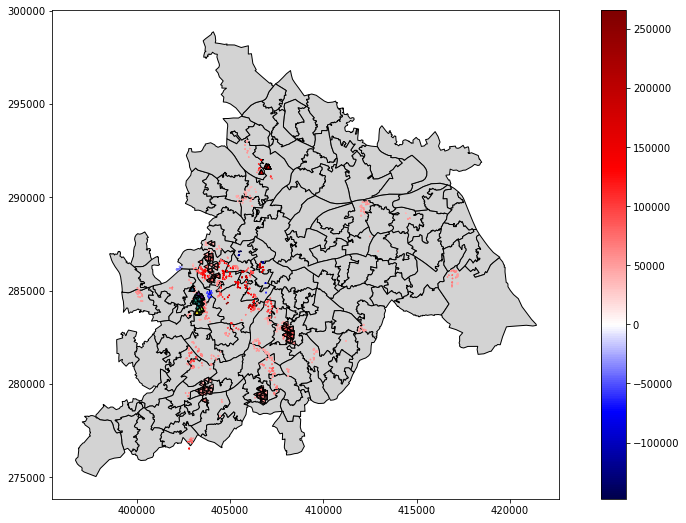

In [368]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo_fil.sentiment_polarity.min()
vmax=georgia_data_geo_fil.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)

bm_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# bm.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)


# df_clu[df_clu['clu']==1].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
df_clu.plot(column='sentiment_polarity', marker='*', markersize=1,cmap=cmap,ax=ax)
df_clu[df_clu['clu']==0].plot(column='sentiment_polarity', marker='^', markersize=20,edgecolor='black',ax=ax)
df_clu[df_clu['clu']==2].plot( column='sentiment_polarity',marker='^', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==8].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==12].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==13].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
df_clu[df_clu['clu']==23].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, edgecolor='black',
        vmin=vmin,vmax=vmax,ax=ax)
# df_clu[df_clu['clu']==14].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)
# ax.set_xlim([395000,422000])
# ax.set_xlim([400000,405000])
# ax.set_ylim([283000,287000])
cbar = f.colorbar(sm)



In [324]:
df_clu.groupby('clu').count()

,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat
clu,,,,,
-1,261,261,261,261,261
0,118,118,118,118,118
1,31,31,31,31,31
2,98,98,98,98,98
3,22,22,22,22,22
4,14,14,14,14,14
5,19,19,19,19,19
6,8,8,8,8,8
7,46,46,46,46,46
